Original Raw Data shape :  (4977, 74)
> Raw Dataset shape :  (4930, 70)
> One-Hot encoded data shape :  (4930, 77)
> Normal data shape :  (1188, 77)
> Normal Feature shape :  (1188, 76)
> Normal Target shape :  (1188, 1)
Epoch 1/200
60/60 - 1s - loss: 0.1292 - val_loss: 0.1238 - 594ms/epoch - 10ms/step
Epoch 2/200
60/60 - 0s - loss: 0.0314 - val_loss: 0.1012 - 85ms/epoch - 1ms/step
Epoch 3/200
60/60 - 0s - loss: 0.0231 - val_loss: 0.0786 - 80ms/epoch - 1ms/step
Epoch 4/200
60/60 - 0s - loss: 0.0201 - val_loss: 0.0542 - 79ms/epoch - 1ms/step
Epoch 5/200
60/60 - 0s - loss: 0.0186 - val_loss: 0.0370 - 81ms/epoch - 1ms/step
Epoch 6/200
60/60 - 0s - loss: 0.0156 - val_loss: 0.0210 - 78ms/epoch - 1ms/step
Epoch 7/200
60/60 - 0s - loss: 0.0158 - val_loss: 0.0134 - 78ms/epoch - 1ms/step
Epoch 8/200
60/60 - 0s - loss: 0.0144 - val_loss: 0.0098 - 79ms/epoch - 1ms/step
Epoch 9/200
60/60 - 0s - loss: 0.0132 - val_loss: 0.0081 - 76ms/epoch - 1ms/step
Epoch 10/200
60/60 - 0s - loss: 0.0142 - val_los

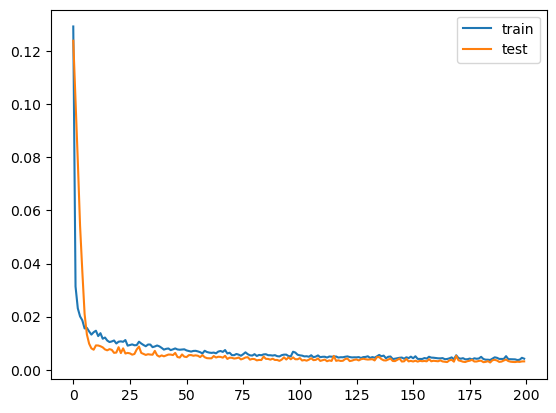

8/8 [==============================] - 0s 658us/step
MAE :  2.35705228809649
MAPE :  1.2008474174420196
R-squared :  0.9038874129291131


In [11]:

'''
Import dependent packages & setup environments
'''
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model 
from matplotlib import pyplot
from sklearn.datasets import make_regression 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import warnings


pd.set_option('display.max.colwidth', 50)
pd.set_option('display.width', 1000)
warnings.filterwarnings(action='ignore')

'''
Load Data 
'''
# Materials to use
materials = ["PC", "PA66", "ABS", "PCSMOG", "TPU"]

# Load raw dataset
raw_dataset = pd.read_excel('../../data/iae/injection_mold_5000_v2.xlsx', header=0, index_col=False)
print("Original Raw Data shape : ", raw_dataset.shape)

raw_dataset = raw_dataset.drop(['id', 'datetime', 'mold_name', 'product_quantity'], axis=1).dropna() #remove 3 columns & drop NA
print("> Raw Dataset shape : ", raw_dataset.shape)

# One-hot Encoding for categorical data
raw_onehot = pd.get_dummies(raw_dataset)   # select onehot encoded featureset from raw data
print("> One-Hot encoded data shape : ", raw_onehot.shape)

# select normal dataset
normal_dataset = raw_onehot.loc[raw_onehot["failure_normal"]==1]
print("> Normal data shape : ", normal_dataset.shape)

normal_target = normal_dataset[["weight"]]
normal_source = normal_dataset.drop('weight', axis=1)
print("> Normal Feature shape : ", normal_source.shape)
print("> Normal Target shape : ", normal_target.shape)

''' 
Auto Encoder for regression
'''
# train autoencoder for regression with no compression in the bottleneck layer
n_inputs = normal_source.shape[1]

X_train, X_test, y_train, y_test = train_test_split(normal_source, np.ravel(normal_target), test_size=0.20, shuffle=True)

# Data Scaler
source_scaler = MinMaxScaler()
source_scaler.fit(normal_source)

X_train_scaled = source_scaler.transform(X_train)
X_test_scaled = source_scaler.transform(X_test)


# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)

# define bottleneck
n_bottleneck = 3#n_inputs
bottleneck = Dense(n_bottleneck)(e)

# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# plot the autoencoder
plot_model(model, 'autoencoder.png', show_shapes=True)

# fit the autoencoder model to reconstruct input
history = model.fit(X_train_scaled, X_train_scaled, epochs=200, batch_size=16, verbose=2, validation_data=(X_test_scaled, X_test_scaled))

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder.png', show_shapes=True)

# save the encoder to file
#encoder.save('encoder.h5')

# reshape target variables so that we can transform them 
y_train = y_train.reshape((len(y_train), 1)) 
y_test = y_test.reshape((len(y_test), 1))

# target data scaler
target_scaler = MinMaxScaler()
target_scaler.fit(normal_target)
y_train = target_scaler.transform(y_train)
y_test = target_scaler.transform(y_test)


# load the model from file 
#encoder = load_model('encoder.h5') 

# encode the train data 
X_train_encode = encoder.predict(X_train_scaled) 

# encode the test data 
X_test_encode = encoder.predict(X_test_scaled) 

# define model 
model = SVR() 

# fit model on the training dataset 
model.fit(X_train_encode, y_train) 

# make prediction on test set 
yhat = model.predict(X_test_encode) 

# invert transforms so we can calculate errors 
yhat = yhat.reshape((len(yhat), 1)) 
yhat = target_scaler.inverse_transform(yhat) 
y_test = target_scaler.inverse_transform(y_test) 

# calculate error 
score = mean_absolute_error(y_test, yhat)
print("MAE : ", score) 

# percentage error
pscore = mean_absolute_percentage_error(y_test, yhat)
print("MAPE : ", pscore*100)

# r squared
r2 = r2_score(y_test, yhat, multioutput='variance_weighted')
print("R-squared : ", r2)


# pyplot.plot(y_test, 'bo', label="Real")
# pyplot.plot(yhat, 'ro', label="Predicted")
# pyplot.legend()
# pyplot.show()

# pyplot.plot(y_test, yhat, 'bo')
# pyplot.xlabel("test")
# pyplot.ylabel("predicted")
# pyplot.show()